# Use SetFit for Active Learning in Small-Text
*Notebook 3*  
In this tutorial we demonstrate how to use [SetFit](https://github.com/huggingface/setfit) as a classifier for active learning.

----

## Overview

- [Part I: Installation](#nb3-part1-installation)
- [Part II: Data](#nb3-part2-data)
- [Part III: Active Learning](#nb3-part3-active-learning)
- [Part IV: Comparison](#nb3-part4-comparison)

----

<a id="nb3-part1-installation"></a>
## I. Installation

The small-text wrapper for SetFit is a part of the transformers integration, so the installation procedure is the same as for every other example that shows small-text with transformers. 

In [1]:
%pip install small-text[transformers]==2.0.0dev2

# setfit is used as an optional dependency here
%pip install setfit==1.1.0
%pip install datasets
%pip install matplotlib

import logging
import warnings

import datasets

import matplotlib.pyplot as plt

plt.rc('figure', titlesize=22)
plt.rc('axes', titlesize=22, labelsize=20, linewidth=1.2)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=16)
plt.rc('lines', linewidth=2)

datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

for logger_name in ['setfit.modeling', 'setfit.trainer']:
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.ERROR)

%env TOKENIZERS_PARALLELISM=false

DEPRECATION: git+https://github.com/webis-de/small-text#egg=small-text[transformers] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/webis-de/small-text to /tmp/pip-install-ztzj5ogn/small-text_9d9785a561904d928205b930a239e326
  Running command git clone --filter=blob:none --quiet https://github.com/webis-de/small-text /tmp/pip-install-ztzj5ogn/small-text_9d9785a561904d928205b930a239e326
  Resolved https://github.com/webis-de/small-text to commit 70885e6a5e8b15c7a7ebaff1ef4cc487ae016826
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to

<a id="nb3-part2-data"></a>
## II. Data

We use the "AG's News" dataset for this demonstration. It consists of news articles which are categorized into four mutually exclusive classes.

In [2]:
import datasets
import logging
import numpy as np


# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

raw_dataset = datasets.load_dataset('ag_news')
num_classes = np.unique(raw_dataset['train']['label']).shape[0]

print('First 10 training samples:\n')
for i in range(10):
    print(raw_dataset['train']['label'][i], ' ', raw_dataset['train']['text'][i])

First 10 training samples:

2   Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
2   Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
2   Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
2   Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.
2   Oil prices soar to all-time record, posing new men

### Preparing the Data

The SetFit Classifier uses the `TextData` structure as input. Such datasets can be easily created from raw text and labels using `TextDataset.from_arrays()`.

In [3]:
import numpy as np
from small_text import TextDataset

num_classes = raw_dataset['train'].features['label'].num_classes

target_labels = np.arange(num_classes)

train = TextDataset.from_arrays(raw_dataset['train']['text'], np.array(raw_dataset['train']['label']), target_labels=target_labels)
test = TextDataset.from_arrays(raw_dataset['test']['text'], np.array(raw_dataset['test']['label']), target_labels=target_labels)

<a id="nb3-part3-active-learning"></a>
## III. Active Learning 

### Configuring the Classifier

In [4]:
from small_text.integrations.transformers.classifiers.setfit import SetFitModelArguments
from small_text.integrations.transformers.classifiers.factories import SetFitClassificationFactory


num_classes = 4

sentence_transformer_model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'
setfit_model_args = SetFitModelArguments(sentence_transformer_model_name)
clf_factory = SetFitClassificationFactory(setfit_model_args, num_classes)

### Setting up the Active Learner

Here, we construct a `PoolBasedActiveLearner` instance which requires a classifier factory, a query strategy, and the train dataset.

To obtain a first model, we initialize the active learner by providing the true labels for 20 sentences. This corresponds to an initial labeling the real-world setting.

In [5]:
from small_text import (
    PoolBasedActiveLearner, 
    random_initialization_balanced,
    BreakingTies,
    SubsamplingQueryStrategy
)

# define a query strategy and initialize a pool-based active learner
query_strategy = SubsamplingQueryStrategy(BreakingTies())
# suppress progress bars in jupyter notebook
setfit_train_kwargs = {'show_progress_bar': False}
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train, fit_kwargs={'setfit_train_kwargs': setfit_train_kwargs})


# simulate a warm start
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize(indices_initial)

    return indices_initial


initial_indices = initialize_active_learner(active_learner, train.y)
labeled_indices = initial_indices

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.256900


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

### Active Learning Loop

The main active learning loop queries the unlabeled pool and thereby decides which documents are labeled next.
We then provide the labels for those documents and the active learner retrains the model.
After each query, we evaluate the current model against the test set and save the result.


Note: This is active learning as it is done in a scientific simulation. In reality, the label feedback would have been given by human annotators.

In [6]:
import gc
import torch
from sklearn.metrics import accuracy_score


num_queries = 10


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc


results_setfit = []
results_setfit.append(evaluate(active_learner, train[labeled_indices], test))

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    q_indices = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[q_indices]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)
    
    # memory fix: https://github.com/UKPLab/sentence-transformers/issues/1793
    gc.collect()
    torch.cuda.empty_cache()

    labeled_indices = np.concatenate([q_indices, labeled_indices])

    print('---------------')
    print('Iteration #{:d} ({} samples)'.format(i, len(labeled_indices)))
    results_setfit.append(evaluate(active_learner, train[labeled_indices], test))


Train accuracy: 1.00
Test accuracy: 0.72


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.271900
50,0.172600


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

---------------
Iteration #0 (40 samples)
Train accuracy: 1.00
Test accuracy: 0.81


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.369300
50,0.208000


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

---------------
Iteration #1 (60 samples)
Train accuracy: 1.00
Test accuracy: 0.83


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.336300
50,0.236200
100,0.108800


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

---------------
Iteration #2 (80 samples)
Train accuracy: 1.00
Test accuracy: 0.86


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.315500
50,0.238400
100,0.111000


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

---------------
Iteration #3 (100 samples)
Train accuracy: 1.00
Test accuracy: 0.85


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.357900
50,0.251400
100,0.119300
150,0.023200


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

---------------
Iteration #4 (120 samples)
Train accuracy: 1.00
Test accuracy: 0.88


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/140 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.335400
50,0.244900
100,0.118100
150,0.013200


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

---------------
Iteration #5 (140 samples)
Train accuracy: 1.00
Test accuracy: 0.87


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.358000
50,0.251800
100,0.154700
150,0.045900
200,0.005600


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

---------------
Iteration #6 (160 samples)
Train accuracy: 1.00
Test accuracy: 0.88


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/180 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.347700
50,0.251900
100,0.155700
150,0.031000
200,0.003100


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

---------------
Iteration #7 (180 samples)
Train accuracy: 1.00
Test accuracy: 0.88


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.333000
50,0.266100
100,0.179700
150,0.052900
200,0.003900
250,0.001700


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

---------------
Iteration #8 (200 samples)
Train accuracy: 1.00
Test accuracy: 0.89


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:262: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/integrations/transformers/classifiers/setfit.py:270: DeprecationWarning: `SetFitTrainer.train` does not accept keyword arguments anymore. Please provide training arguments via a `TrainingArguments` instance to the `SetFitTrainer` initialisation or the `SetFitTrainer.train` method.
  trainer.train(max_length=self.max_seq_len, **setfit_train_kwargs)


Step,Training Loss
1,0.387900
50,0.262400
100,0.174700
150,0.052800
200,0.004400
250,0.001700


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

---------------
Iteration #9 (220 samples)
Train accuracy: 1.00
Test accuracy: 0.89


## Plotting the Results

With the previous results we can plot a [learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) to visualize the performance.

<module 'matplotlib.pyplot' from '/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/matplotlib/pyplot.py'>

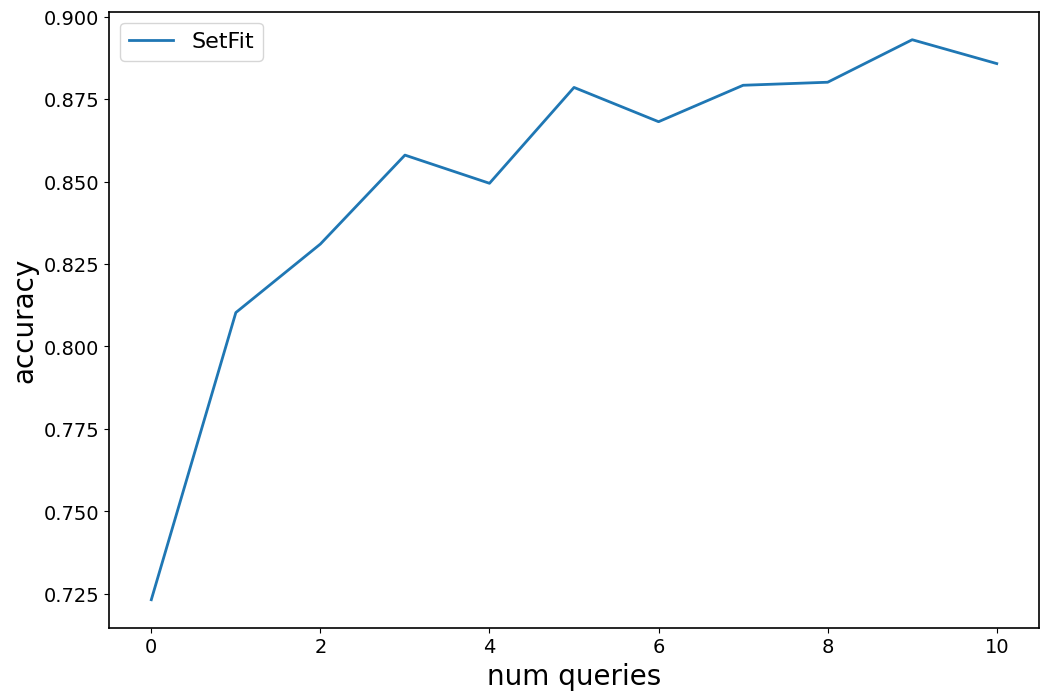

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

ax.plot(np.arange(num_queries+1), results_setfit, label='SetFit')
ax.legend()

plt.ylabel('accuracy')
plt.xlabel('num queries')

display(plt)

<a id="nb3-part4-comparison"></a>
## IV. Comparing against BERT

We perform the same steps again for BERT.

In [8]:
import numpy as np

from small_text import TransformersDataset
from transformers import AutoTokenizer


transformer_model_name = 'bert-base-uncased'

tokenizer_kwargs = {'clean_up_tokenization_spaces': True}
tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name,
    **tokenizer_kwargs
)

num_classes = raw_dataset['train'].features['label'].num_classes

target_labels = np.arange(num_classes)
max_length = 128


train = TransformersDataset.from_arrays(raw_dataset['train']['text'], 
                                        np.array(raw_dataset['train']['label']), 
                                        tokenizer,
                                        target_labels=target_labels,
                                        max_length=max_length)
test = TransformersDataset.from_arrays(raw_dataset['test']['text'], 
                                       np.array(raw_dataset['test']['label']), 
                                       tokenizer,
                                       target_labels=target_labels,
                                       max_length=max_length)

In [9]:
from small_text import TransformerBasedClassificationFactory, TransformerModelArguments

model_args = TransformerModelArguments(transformer_model_name, tokenizer_kwargs=tokenizer_kwargs)
clf_factory = TransformerBasedClassificationFactory(model_args, num_classes)

In [10]:
from small_text import (
    PoolBasedActiveLearner, 
    random_initialization_balanced,
    BreakingTies,
    SubsamplingQueryStrategy
)

# define a query strategy and initialize a pool-based active learner
query_strategy = SubsamplingQueryStrategy(BreakingTies())
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)


# use the same initial set as above
active_learner.initialize(initial_indices)
labeled_indices = initial_indices

In [11]:
results_bert = []
results_bert.append(evaluate(active_learner, train[labeled_indices], test))

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    q_indices = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[q_indices]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    labeled_indices = np.concatenate([q_indices, labeled_indices])
    
    print('---------------')
    print('Iteration #{:d} ({} samples)'.format(i, len(labeled_indices)))
    results_bert.append(evaluate(active_learner, train[labeled_indices], test))


Train accuracy: 0.85
Test accuracy: 0.41
---------------
Iteration #0 (40 samples)
Train accuracy: 0.95
Test accuracy: 0.60
---------------
Iteration #1 (60 samples)
Train accuracy: 0.90
Test accuracy: 0.65
---------------
Iteration #2 (80 samples)
Train accuracy: 0.93
Test accuracy: 0.70
---------------
Iteration #3 (100 samples)
Train accuracy: 0.96
Test accuracy: 0.78
---------------
Iteration #4 (120 samples)
Train accuracy: 0.97
Test accuracy: 0.79
---------------
Iteration #5 (140 samples)
Train accuracy: 0.99
Test accuracy: 0.84
---------------
Iteration #6 (160 samples)
Train accuracy: 0.96
Test accuracy: 0.81
---------------
Iteration #7 (180 samples)
Train accuracy: 0.97
Test accuracy: 0.86
---------------
Iteration #8 (200 samples)
Train accuracy: 0.97
Test accuracy: 0.87
---------------
Iteration #9 (220 samples)
Train accuracy: 0.98
Test accuracy: 0.86


### Comparison

This time we plot the learning curves of SetFit and BERT. Not only does SetFit run quite fast (albeit we did not measure the runtime here) but also its learning curve is quite steep.

Do not draw any conclusions from this besides the impressive performance and runtime of SetFit. The comparison itself is not really fair and should be in favor of `bert-base-uncased` which has 12 layers and outputs embeddings of size 768 compared to `paraphrase-MiniLM-L3-v2` which has only three layers and outputs embeddings of size 384.

<module 'matplotlib.pyplot' from '/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/matplotlib/pyplot.py'>

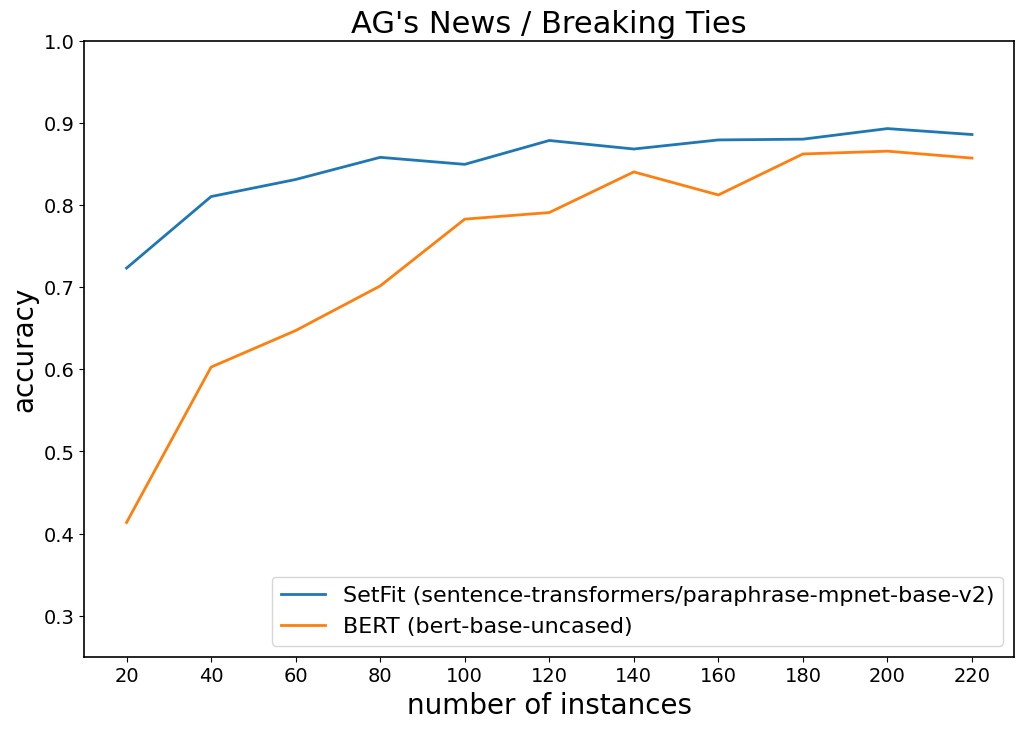

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

ax.plot(np.arange(20, 240, 20), results_setfit, label=f'SetFit ({sentence_transformer_model_name})')
ax.plot(np.arange(20, 240, 20), results_bert, label=f'BERT ({transformer_model_name})')
ax.legend(loc='lower right')

plt.xticks(np.arange(20, 240, 20))
plt.ylim((0.25, 1.0))

plt.ylabel('accuracy')
plt.xlabel('number of instances')

plt.title('AG\'s News / Breaking Ties')


display(plt)